## Скрипт для скачивания OSISAF

In [37]:
import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime

#ice_conc_nh_ease2-250_icdr-v3p0_202502071200.nc
def name_format(time: str, archive=True):
    #return f'ice_conc_nh_ease2-250_cdr-v3p1_{time}1200.nc'
    return f'ice_conc_nh_ease2-250_icdr-v3p0_{time}1200.nc'

def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_pack(folder_to_save, start_day, end_day):
    # Проверяем, что даты не в будущем
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Warning: End date {end_day} is in the future. Adjusting to today {today}")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    remote_dir = 'reprocessed/ice/conc-cont-reproc/v3p0'
    
    # Создаем одно подключение для всех файлов
    with ftplib.FTP('osisaf.met.no') as ftp:
        ftp.login()
        print("Connected to FTP server")
        
        # Создаем словарь для кэширования проверенных директорий
        valid_dirs = {}
        
        for date in dates:
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            file_name = name_format(date_str)
            
            # Проверяем существование файла локально
            local_path = Path(folder_to_save, file_name)
            if local_path.exists():
                print(f'Skipping existing file: {file_name}')
                continue
                
            # Формируем путь на сервере
            remote_path = f"{remote_dir}/{year}/{month}"
            
            # Проверяем, была ли директория уже проверена
            if remote_path in valid_dirs:
                if valid_dirs[remote_path] is False:
                    print(f"Skipping known invalid directory: {remote_path}")
                    continue
            else:
                # Проверяем существование директории
                try:
                    # Используем команду CWD для проверки существования директории
                    ftp.cwd(remote_path)
                    valid_dirs[remote_path] = True
                    print(f"Directory valid: {remote_path}")
                except ftplib.error_perm as e:
                    print(f"Directory not found: {remote_path} ({str(e)})")
                    valid_dirs[remote_path] = False
                    continue
            
            try:
                # Получаем список файлов в директории
                file_list = ftp.nlst()
                if file_name not in file_list:
                    print(f"File not found on server: {file_name}")
                    continue
                
                # Скачиваем файл
                if download(folder_to_save, file_name, ftp, silent=False):
                    print(f"Successfully downloaded: {file_name}")
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
                continue

# Пример вызова с актуальными датами
folder_to_save = 'osisaf_data'
download_pack(folder_to_save, '20250201', '20250205') 

Connected to FTP server
Directory valid: reprocessed/ice/conc-cont-reproc/v3p0/2025/02
Downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502011200.nc
Successfully downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502011200.nc
Downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502021200.nc
Successfully downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502021200.nc
Downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc
Successfully downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc
Downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502041200.nc
Successfully downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502041200.nc
Downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502051200.nc
Successfully downloaded: ice_conc_nh_ease2-250_icdr-v3p0_202502051200.nc


## Скрипт для скачивания MASIE 

In [42]:
## import ftplib
import os
from pathlib import Path
import pandas as pd
from datetime import datetime, date

def day_of_year(year, month, day):
    date_obj = date(year, month, day)
    return '%03d' % date_obj.timetuple().tm_yday
    
#masie_all_r00_v01_2025001_4km.nc
def masie_name_format(date_str: str):
    #return f'masie_4km_ice_r00_v01_{date_str}.nc'
    return f'masie_all_r00_v01_{date_str}_1km.nc'


def download(folder_to_save, file_name, ftp, silent=False):
    os.makedirs(folder_to_save, exist_ok=True)
    file_path = Path(folder_to_save, file_name)
    
    if file_path.exists():
        if not silent:
            print(f'{file_name} already exists')
        return True
            
    try:
        with open(file_path, 'wb') as f:
            ftp.retrbinary(f'RETR {file_name}', f.write)
        if not silent:
            print(f'Downloaded: {file_name}')
        return True
    except Exception as e:
        if not silent:
            print(f'Error downloading {file_name}: {e}')
        if file_path.exists():
            file_path.unlink()
        return False

def download_masie(folder_to_save, start_day, end_day):
    today = datetime.today().strftime('%Y%m%d')
    if end_day > today:
        print(f"Adjusting end date to today ({today})")
        end_day = today
    
    dates = pd.date_range(start_day, end_day, freq='1D')
    base_dir = '/DATASETS/NOAA/G02186/netcdf/1km'
    
    with ftplib.FTP('sidads.colorado.edu') as ftp:
        ftp.login()  # Анонимный вход
        print("Connected to NSIDC FTP server")
        
        valid_dirs_cache = {}
        
        for date in dates:
            
            year = date.strftime('%Y')
            month = date.strftime('%m')
            date_str = date.strftime('%Y%m%d')
            
            y, m, d = int(date_str[0:4]), int(date_str[4:6]), int(date_str[6:8]) 
            day_number = day_of_year(y, m, d)
            
            file_name = masie_name_format(f"{year}{day_number}")
            local_path = Path(folder_to_save, file_name)
            
            # Пропустить существующие файлы
            if local_path.exists():
                print(f'Skipping: {file_name}')
                continue
                
            # Формирование пути на сервере
            remote_dir = f"{base_dir}/{year}" #{day_number}" #/{month}"
            
            # Проверка директории в кэше
            if remote_dir in valid_dirs_cache:
                if not valid_dirs_cache[remote_dir]:
                    continue
            else:
                try:
                    ftp.cwd(remote_dir)
                    valid_dirs_cache[remote_dir] = True
                    print(f"Directory accessible: {remote_dir}")
                except ftplib.error_perm:
                    print(f"Directory not found: {remote_dir}")
                    valid_dirs_cache[remote_dir] = False
                    continue
            
            # Проверка наличия файла
            try:
                if file_name not in ftp.nlst():
                    print(f"File not available: {file_name}")
                    continue
                    
                download(folder_to_save, file_name, ftp)
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

# Пример использования
folder_to_save = 'masie_data'
download_masie(folder_to_save, '20250201', '20250205')

Connected to NSIDC FTP server
Directory accessible: /DATASETS/NOAA/G02186/netcdf/1km/2025
Downloaded: masie_all_r00_v01_2025032_1km.nc
Downloaded: masie_all_r00_v01_2025033_1km.nc
Downloaded: masie_all_r00_v01_2025034_1km.nc
Downloaded: masie_all_r00_v01_2025035_1km.nc
Downloaded: masie_all_r00_v01_2025036_1km.nc


## Plot files

Рисовать буду за 03.02.2025
Снимки:
1. osisaf
2. masie
3. Geotiff (оптика)
4. Гибридный снимок

tutor plot: https://medium.com/@Manjar-Alam/clipping-and-visualizing-netcdf-data-using-python-84dfbbbce0a5

In [40]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd

In [44]:
ds = xr.open_dataset('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/osisaf_data/ice_conc_nh_ease2-250_icdr-v3p0_202502031200.nc')

In [45]:
ds

<xarray.Dataset> Size: 10MB
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 8B 2025-02-03T12:00:00
  * xc                              (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 746kB ...
    lon                             (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 4B ...
    time_bnds                       (time, nv) datetime64[ns] 16B ...
    ice_conc                        (time, yc, xc) float64 1MB ...
    raw_ice_conc_values             (time, yc, xc) float64 1MB ...
    total_standard_uncertainty      (time, yc, xc) float64 1MB ...
    smearing_standard_uncertainty   (time, yc, xc) float64 1MB ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 1MB ...
    status_flag                     (time, yc, xc) float32 746kB ...
Attributes: (12/43)
    title:                     Interim Sea Ice Concentration Climate Data Rec...
    summary:                   This Interim Climate Data Record implements an...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        16.62393
    ...                        ...
    Conventions:               CF-1.7,ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (Version 78, 21 Septemb...
    product_id:                osi-430-a
    product_name:              osi_saf_sea_ice_conc_climate_data_record_interim
    product_status:            operational
    doi:                       10.15770/EUM_SAF_OSI_0014

TypeError: '<' not supported between instances of 'str' and 'int'

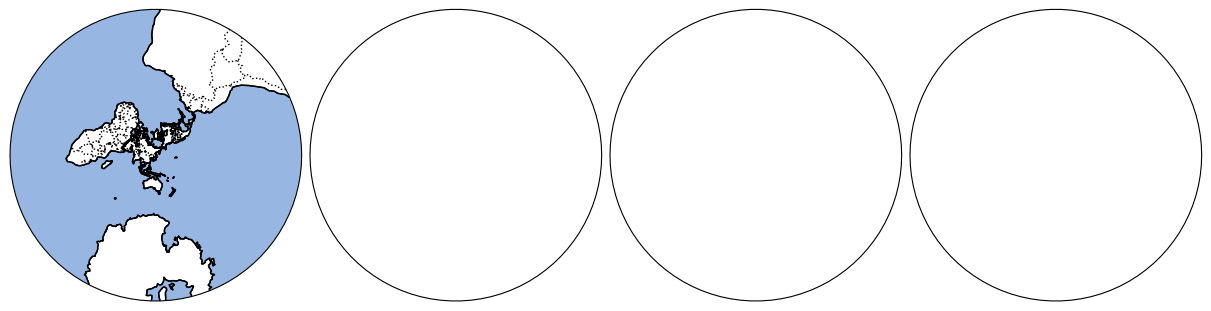

In [94]:
#fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.Stereographic(central_latitude=50, central_longitude=140)})

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, 8),
                        layout="constrained",
                        subplot_kw={'projection': ccrs.Stereographic(central_latitude=50, central_longitude=140)}
                        )

axs[0].coastlines()
axs[0].add_feature(cfeature.OCEAN)
axs[0].add_feature(cfeature.COASTLINE)
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].add_feature(cfeature.STATES, linestyle=':')

# Add gridlines with labels
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.7)
gridlines.top_labels = False
gridlines.right_labels = False
gridlines.left_labels = True
gridlines.bottom_labels = True

# Adjust the padding and font size of the labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}

import cmocean as cm

# 1. Plot OSISAF
mesh = axs[0].pcolormesh(
    ds['lon'].values, 
    ds['lat'].values, 
    ds['ice_conc'].values[0,:,:], 
    cmap=cm.cm.ice, 
    transform=ccrs.PlateCarree()
)

# Добавление цветовой шкалы
cbar = plt.colorbar(mesh, ax=axs[0], orientation='vertical', pad=0.05, shrink=0.4)
cbar.set_label('ice conc')

axs[0].set_extent((135, 155, 40, 65), crs=ccrs.PlateCarree())
axs[0].set_title('OSISAF')

# 4. Plot satellite images
import rioxarray as rxr

fname = '/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/snapshot-2025-02-03T00_00_00Z.tif'
img = rxr.open_rasterio('/home/voland/dev/projects/nss_lab/osisaf_masie_qgis/snapshot-2025-02-03T00_00_00Z.tif')
img.plot(transform=ccrs.PlateCarree())


# Заголовок
#plt.title('Osisaf')

plt.show()

In [91]:
pip install gdal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.7/877.7 kB 1.0 MB/s eta 0:00:001.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdal: filename=gdal-3.11.0-cp313-cp313-linux_x86_64.whl size=5965771 sha256=c7ce9659c790b46dbd237322f569040ee19dcdcdcc8ef6a25d2de3bbbdc41bb8
  Stored in directory: /home/voland/.cache/pip/wheels/95/d3/fa/68de4416ef21dd715ed33e8d93c017ac84b331d087d74c4569
Successfully built gdal
Note: you may need to restart the kernel to use updated packages.


In [59]:
ds['ice_conc']

<xarray.DataArray 'ice_conc' (time: 1, yc: 432, xc: 432)> Size: 1MB
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan]]], shape=(1, 432, 432))
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-02-03T12:00:00
  * xc       (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat      (yc, xc) float32 746kB 16.62 16.82 17.02 ... 17.02 16.82 16.62
    lon      (yc, xc) float32 746kB -135.0 -135.1 -135.3 ... 44.73 44.87 45.0
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_uncertainty status_flag
    comment:              this field is the primary sea ice concentration est...